In [8]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Função para calcular o SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


In [10]:
# Função para carregar os dados de exportação
def carregar_dados_exportacao():
    caminho_exportacao = r"C:\Users\lucas\Documents\GitHub\api-etl-pipeline\etl\output\dados_exportacao.csv"
    df_exportacao = pd.read_csv(caminho_exportacao)

    # Transformar 'ano' em datetime e verificar duplicatas
    df_exportacao['ano'] = pd.to_datetime(df_exportacao['ano'], format='%Y')
    df_exportacao = df_exportacao.groupby('ano').agg({'quantidade_kg': 'sum'}).reset_index()

    # Renomear colunas para Prophet
    df_exportacao = df_exportacao.rename(columns={'ano': 'ds', 'quantidade_kg': 'y'})
    
    return df_exportacao

In [15]:
# Função para treinar o modelo Prophet com melhorias
def treinar_modelo_prophet(df_treino, changepoint_prior_scale=0.02, seasonality_prior_scale=15, yearly_fourier_order=15, quarterly_fourier_order=10):
    modelo = Prophet(
        changepoint_prior_scale=changepoint_prior_scale, 
        seasonality_prior_scale=seasonality_prior_scale
    )
    
    # Adicionar sazonalidade anual e trimestral
    modelo.add_seasonality(name='yearly', period=365.25, fourier_order=yearly_fourier_order)
    modelo.add_seasonality(name='quarterly', period=365.25/4, fourier_order=quarterly_fourier_order)
    
    modelo.fit(df_treino)
    
    # Previsão para os próximos 10 anos
    futuro = modelo.make_future_dataframe(periods=10, freq='Y')
    previsoes = modelo.predict(futuro)
    return previsoes

In [16]:
# Função para plotar previsões e dados reais
def plot_previsoes(df_real, previsoes, titulo="Previsão Prophet"):
    plt.figure(figsize=(10, 6))
    
    # Plotar os valores reais
    plt.plot(df_real['ds'], df_real['y'], label='Dados Reais', color='blue', marker='o')
    
    # Plotar as previsões
    plt.plot(previsoes['ds'], previsoes['yhat'], label='Previsão', color='red', linestyle='--', marker='x')
    
    # Configurações do gráfico
    plt.title(titulo)
    plt.xlabel('Ano')
    plt.ylabel('Quantidade Exportada (kg)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    # Salvar a figura
    plt.savefig(r"C:\Users\lucas\Documents\GitHub\api-etl-pipeline\model\output\exportacao\exportacao_graf_prophet.png")
    plt.show()

In [17]:
# Função principal para dividir os dados e fazer previsões
def main():
    df_exportacao = carregar_dados_exportacao()

    # Pegar os primeiros 20 anos de dados para o treinamento (até 1989)
    df_treino = df_exportacao[df_exportacao['ds'].dt.year <= 1989]
    
    # Treinar o modelo com os primeiros 20 anos
    previsoes_teste = treinar_modelo_prophet(
        df_treino, 
        changepoint_prior_scale=0.02, 
        seasonality_prior_scale=20, 
        yearly_fourier_order=20,  # Mais Fourier terms
        quarterly_fourier_order=15  # Mais Fourier terms
    )
    
    # Fazer previsões para os próximos anos (a partir de 1990)
    df_teste = df_exportacao[df_exportacao['ds'].dt.year >= 1990]
    
    # Ajustar previsões ao ano dos dados de teste
    previsoes_teste.loc[:, 'ano'] = previsoes_teste['ds'].dt.year
    df_teste = df_teste.copy()
    df_teste.loc[:, 'ano'] = df_teste['ds'].dt.year
    
    # Filtrar previsões que correspondem aos anos de teste
    previsoes_teste_filtradas = previsoes_teste[previsoes_teste['ano'].isin(df_teste['ano'])]
    
    # Comparar previsões com dados reais (combinando os anos)
    df_teste_alinhado = df_teste[df_teste['ano'].isin(previsoes_teste_filtradas['ano'])]
    
    mae = mean_absolute_error(df_teste_alinhado['y'], previsoes_teste_filtradas['yhat'])
    rmse = np.sqrt(mean_squared_error(df_teste_alinhado['y'], previsoes_teste_filtradas['yhat']))
    smape_value = smape(df_teste_alinhado['y'], previsoes_teste_filtradas['yhat'])
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"SMAPE: {smape_value:.2f}%")    
    
    # Plotar previsões e dados reais
    df_combined = pd.concat([df_treino, df_teste_alinhado])
    plot_previsoes(df_combined, previsoes_teste)

03:13:23 - cmdstanpy - INFO - Chain [1] start processing
03:13:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


MAE: 11103007.31
RMSE: 13928559.26
SMAPE: 59.23%


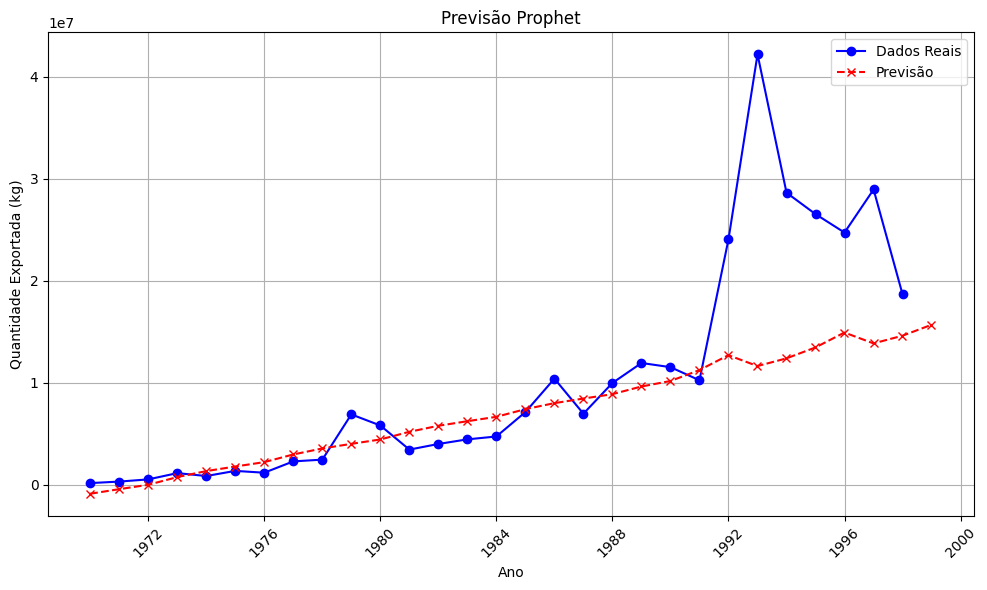

In [18]:
if __name__ == "__main__":
    main()
